<a href="https://colab.research.google.com/github/Smakson/GAN/blob/master/GAN2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

"""Dataset creation"""
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path = "drive/My Drive/Colab Notebooks/X_test_sat6.csv"
df = pd.read_csv(path)
images = df.to_numpy()

newimages = []
for i in range(len(images)):
  oldimage = images[i]
  newimage = np.reshape(oldimage, [28, 28, 4])
  newimages.append(newimage[:,:,:3])
del images
newimages = np.array(newimages)

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  
  hid = Dense(128 * 14 * 14, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((14, 14, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [0]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [0]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

path_save = "drive/My Drive/Colab Notebooks/"

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.savefig(path_save + batchidx +'.jpg')
  plt.show()
  plt.close()

In [0]:
# GAN creation
img_input = Input(shape=(28,28,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)
generator.trainable = True

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
__________

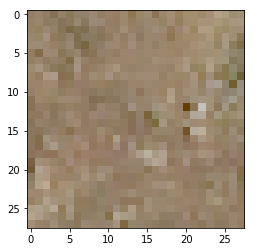

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.imshow(newimages[22570])

In [0]:
BATCH_SIZE = 16

# # Get training images
X_train = newimages


# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)
print(num_batches)

5062


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 1, Generator Loss: 1.9411196145087375, Discriminator Loss: [0.48202768 0.        ]


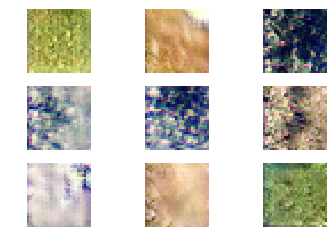

0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 2, Generator Loss: 1.8233107534534891, Discriminator Loss: [0.49695703 0.        ]


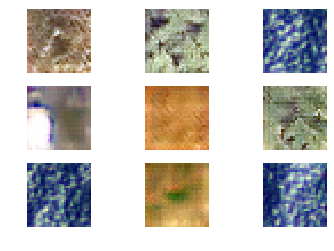

0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 3, Generator Loss: 1.7373646928453013, Discriminator Loss: [0.51142365 0.        ]


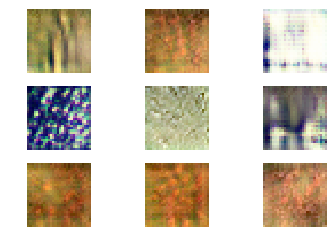

0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 4, Generator Loss: 2.0114694260611263, Discriminator Loss: [0.46063718 0.        ]


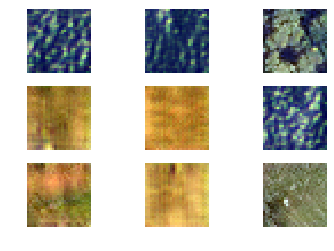

0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 5, Generator Loss: 1.7901773552109677, Discriminator Loss: [0.4842899 0.       ]


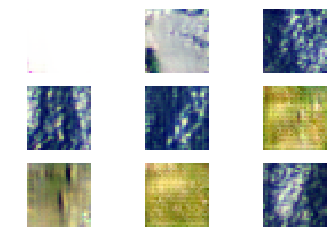

0 batches done
1000 batches done
2000 batches done
3000 batches done
4000 batches done
5000 batches done
  Epoch: 6, Generator Loss: 1.7979524803198124, Discriminator Loss: [0.48525992 0.        ]


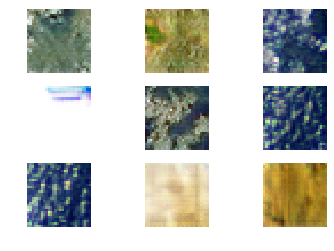

0 batches done


KeyboardInterrupt: ignored

In [0]:
N_EPOCHS = 100
dloss = []
gloss = []
path_save = "drive/My Drive/Colab Notebooks/"

for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
    if batch_idx % 1000 == 0:
      print("{} batches done".format(batch_idx))
  if epoch > 10 and epoch % 10 == 0:
    discriminator.save(path_save + "discr_" + str(epoch) + ".h5")
    generator.save(path_save + "generat_" + str(epoch) + ".h5")
    dloss.append(d_loss)
    gloss.append(g_loss)
  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
print(dloss)
print(gloss)

with open(path_save + "dloss.txt",'w') as file:
  file.write(str(dloss))

with open(path_save + "gloss.txt",'w') as file:
  file.write(str(gloss))

In [0]:
with open(path_save + "dloss.txt",'w') as file:
  file.write(str(dloss))

with open(path_save + "gloss.txt",'w') as file:
  file.write(str(gloss))

In [0]:
from keras.models import load_model


path_save = "drive/My Drive/Colab Notebooks/"
disc90  = load_model(path_save + "discr_" + '90.h5')
gan90 = load_model(path_save + "gan_" + '90.h5')
print(gan90.summary())
layer_name = 'model_2'
gen_layer = gan90.get_layer(layer_name)


In [0]:
noise_data = generate_noise(16, 100)
imgs = gen_layer.predict(noise_data)
plt.imshow(imgs[15])

In [0]:
dloss = [0.46878597, 0.46384513, 0.45458752, 0.44792107, 0.44687173, 0.44274542, 0.4387593, 0.42690095, 0.42059174, 0.41528568, 0.40410402, 0.3951887, 0.3955003, 0.3795435, 0.37725633, 0.3774827, 0.36887544, 0.36692482, 0.36140177, 0.35719246, 0.3508914, 0.34916118, 0.34388593, 0.34325135, 0.33901963, 0.33279955, 0.33422703, 0.32556412, 0.3278699, 0.32021853, 0.3220012, 0.32001802, 0.31667686, 0.3137586, 0.3114294, 0.30895057, 0.30432868, 0.30888903, 0.30649564, 0.3022441, 0.2877166, 0.3003527, 0.29606175, 0.29827484, 0.28873113, 0.28235844, 0.30372202, 0.2906238, 0.28800204, 0.29022413, 0.28591815, 0.28548795, 0.28241616, 0.28651768, 0.28378844, 0.28709722, 0.28384572, 0.284493, 0.283233, 0.27338246, 0.27731907, 0.2865796, 0.28116232, 0.28297105, 0.27933383, 0.2833322, 0.27910417, 0.27843398, 0.2772752, 0.27676818, 1.0, 6.0, 0.27560437, 0.27659398, 0.27970946, 0.27749527, 0.2768177, 0.28268853, 0.28262374, 0.2851205, 0.28773096, 0.28547555, 0.29641724, 0.28737053, 0.29103875, 0.29371145, 0.28924632, 0.2989692, 0.31604174, 0.3095437, 0.288488, 0.29428542, 0.28857785, 0.2847277, 0.2957442, 0.31026888, 0.2914304, 0.32893685, 0.3216385, 0.3130923]
gloss = [1.6364911377197406, 1.6446091191160943, 1.708999583327643, 1.7194059512161046, 1.7494645214355167, 1.7552304961882363, 1.7998607033419896, 1.8271128367360332, 1.8511371792123716, 1.8818606250620982, 1.9524311502031755, 2.033564387157954, 2.0383365657305657, 2.0824403595745986, 2.0851889528515914, 2.1099797598105066, 2.1794311841460425, 2.219299276533427, 2.216524578557331, 2.245367551819285, 2.315547604111609, 2.3196186431956263, 2.3494375060356236, 2.3590668856329313, 2.372071327341346, 2.449220899864884, 2.3828477570187285, 2.374911202669014, 2.4558719528514446, 2.481261339275581, 2.4602223586037915, 2.5251955960147563, 2.5366928158913002, 2.5309320671100455, 2.5597829548976887, 2.571439592551156, 2.560036430487881, 2.5754725764167405, 2.551436804339484, 2.6132410464109945, 2.6101727595001587, 2.6515049582817536, 2.6479803276675487, 2.647475906068195, 2.7145273384532524, 2.6729170568096032, 2.6506724141064204, 2.6675169546641366, 2.664361423448888, 2.697277340681797, 2.6814741253711545, 2.691806515542616, 2.6919136081863795, 2.6700085580675723, 2.6814573291955566, 2.6714578416479617, 2.726027073945772, 2.6285572109699062, 2.648964988417314, 2.665326521495311, 2.664156714315202, 2.6297765806028846, 2.6515278871167864, 2.6481375548501394, 2.6683994033081357, 2.694905781100645, 2.6919142231580677, 2.664116335117984, 2.627673046190199, 2.6533784672841634, 2.674516928740249, 2.6956636446168636, 2.6692396451121896, 2.6058459529106393, 2.7055665315793043, 2.7116232759962084, 2.658231801092507, 2.6515591027931187, 2.680190222902302, 2.651958485253535, 2.6644219130120144, 2.581424140644045, 2.6510403705197847, 2.625888064747999, 2.647685841822438, 2.639399306914143, 2.5957492856240374, 2.538085550060978, 2.4873180926119867, 2.574380946032488, 2.565822183748053, 2.5947506962081324, 2.6561675898234736, 2.6108863243986993, 2.5133002420665838, 2.4815691252651537, 2.3651832405379145, 2.4235118294222313, 2.474073116290035, 2.412961634724496]
dloss = np.array(dloss)
gloss = np.array(gloss)

In [0]:
tab = [i for i in range(100)]
plt.plot(tab, dloss, label = "Discrimnator loss", color = "green")
plt.plot(tab, gloss, label = "Generator loss", color = "blue")
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.title('Loss of G and D through the epochs', fontsize = 16)
plt.legend()
plt.savefig(path_save + "loss_plot.jpg")
plt.show()
